In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys; sys.path.insert(0, '..')
from scripts.python.readii_analysis.data.helpers import (
    loadFeatureFilesFromImageTypes, 
    loadImageDatasetConfig,
    makeProcessedDataFolders )
from scripts.python.readii_analysis.analyze.correlation_functions import (
    getFeatureCorrelations, 
    makeBothCrossCorrelationPlots, makeBothSelfCorrelationPlots)

# Analysis Settings

In [2]:
dataset_name = "RADCURE"
extraction_method = "deep_learning"
extracted_feature_dir = "train_test_split/train_features"
self_dist_num_bins = 450
self_dist_y_upper_bound = None
cross_dist_num_bins = 450
cross_dist_y_upper_bound = None

In [25]:
PROC_DATA_PATH = "../../procdata/"
RESULTS_DATA_PATH = "../../results/"
CONFIG_DIR_PATH = "../config/"
CORRELATION_METHOD = "pearson"
CORR_COLOR_MAP = "RdYlGn"

# Load config file

In [4]:
config = loadImageDatasetConfig(dataset_name, CONFIG_DIR_PATH)

# Setup Results directory

In [5]:
# Results data folder creation
makeProcessedDataFolders(dataset_name=dataset_name,
                        proc_data_path=RESULTS_DATA_PATH,
                        data_sources=extraction_method,
                        data_types=["correlation_distribution_plots", "correlation_heatmap_plots"])
heatmap_dir_path=os.path.join(RESULTS_DATA_PATH, dataset_name, extraction_method.lower(), "correlation_heatmap_plots")
dist_dir_path=os.path.join(RESULTS_DATA_PATH, dataset_name, extraction_method.lower(), "correlation_distribution_plots")

# Load all feature sets

In [6]:
# Load in all processed feature sets - should have one file for each image type in the extracted_image_feature_dir
extracted_image_feature_dir = os.path.join(PROC_DATA_PATH, dataset_name, extraction_method, extracted_feature_dir)
image_feature_sets = loadFeatureFilesFromImageTypes(extracted_feature_dir = extracted_image_feature_dir,
                                                    image_types=config["image_types"],
                                                    drop_labels=True,
                                                    labels_to_drop=["patient_ID","survival_time_in_years","survival_event_binary"])


print("Feature sets available for analysis:")
for feature_set in image_feature_sets.keys():
    print("  ->", feature_set)

Feature sets available for analysis:
  -> original
  -> shuffled_full
  -> shuffled_roi
  -> shuffled_non_roi
  -> randomized_sampled_full
  -> randomized_sampled_roi
  -> randomized_sampled_non_roi


# Correlation Calculations

In [23]:
# Set up which feature sets to analyze
# This feature set will be used for the vertical axis (y-axis)
vertical_feature_name = "original"
# This feature set will be used for the horizontal axis (x-axis)
horizontal_feature_name = "shuffled_full"

In [24]:
# Set up features for correlation calculation
vertical_features = image_feature_sets[vertical_feature_name]
horizontal_features = image_feature_sets[horizontal_feature_name]

# Select method
correlation_method = "pearson"

# Calculate Pearson correlation matrix
feature_correlation_matrix = getFeatureCorrelations(vertical_features = vertical_features, 
                                                    horizontal_features = horizontal_features,
                                                    method = correlation_method,
                                                    vertical_feature_name=vertical_feature_name,
                                                    horizontal_feature_name=horizontal_feature_name)

# Correlation Plots

## Vertical Features Plots

Correlation matrix is symmetric.


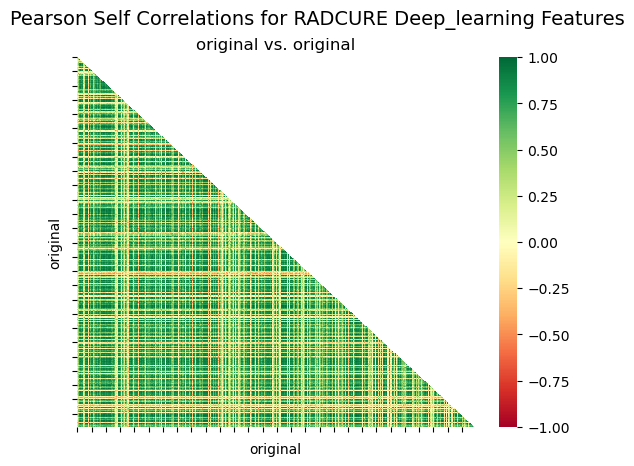

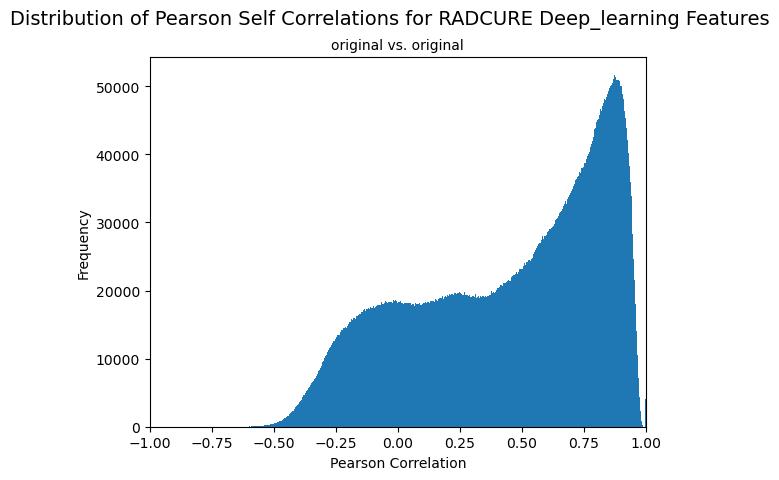

In [26]:
vertical_self_corr_plot, vertical_self_corr_dist_plot = makeBothSelfCorrelationPlots(correlation_matrix = feature_correlation_matrix,
                                                                                      axis = "vertical",
                                                                                      num_axis_features = len(vertical_features.columns),
                                                                                      feature_name = vertical_feature_name,
                                                                                      corr_cmap = CORR_COLOR_MAP,
                                                                                      dist_num_bins = self_dist_num_bins,
                                                                                      dist_y_upper_bound = self_dist_y_upper_bound,
                                                                                      correlation_method = correlation_method,
                                                                                      extraction_method = extraction_method,
                                                                                      dataset_name = dataset_name)

## Horizontal Feature Plots

Correlation matrix is symmetric.


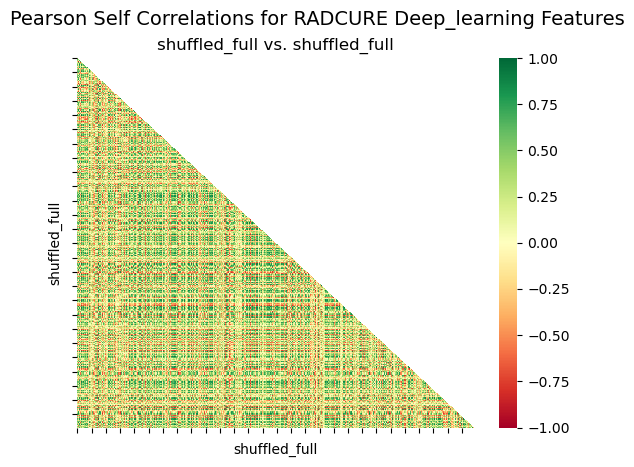

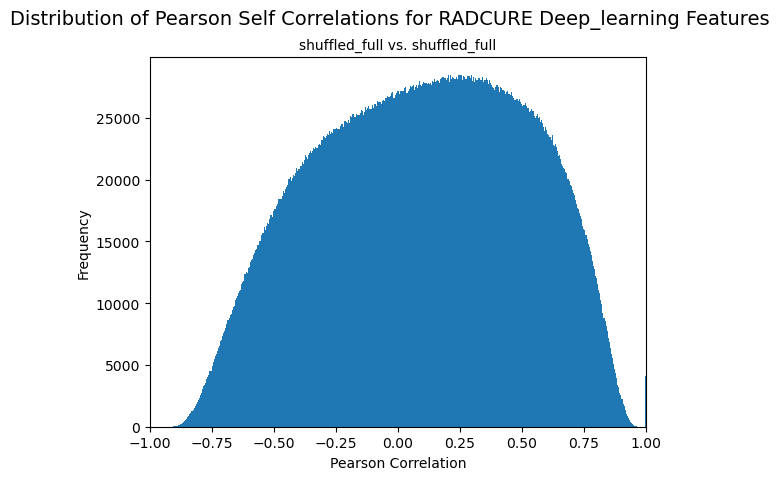

In [27]:
horizontal_self_plot = makeBothSelfCorrelationPlots(correlation_matrix = feature_correlation_matrix,
                                                     axis = "horizontal",
                                                     num_axis_features=len(horizontal_features.columns),
                                                     feature_name=horizontal_feature_name,
                                                     corr_cmap = CORR_COLOR_MAP,
                                                     dist_num_bins = self_dist_num_bins,
                                                     dist_y_upper_bound = self_dist_y_upper_bound,
                                                     correlation_method = CORRELATION_METHOD,
                                                     extraction_method = extraction_method,
                                                     dataset_name = dataset_name)

### Vertical vs. Horizontal Feature Correlations

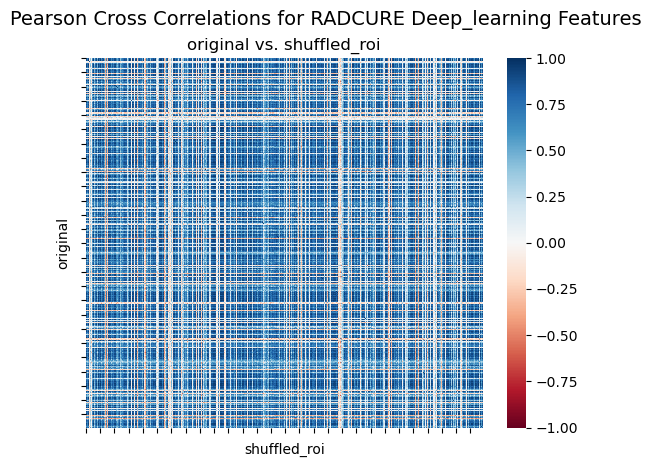

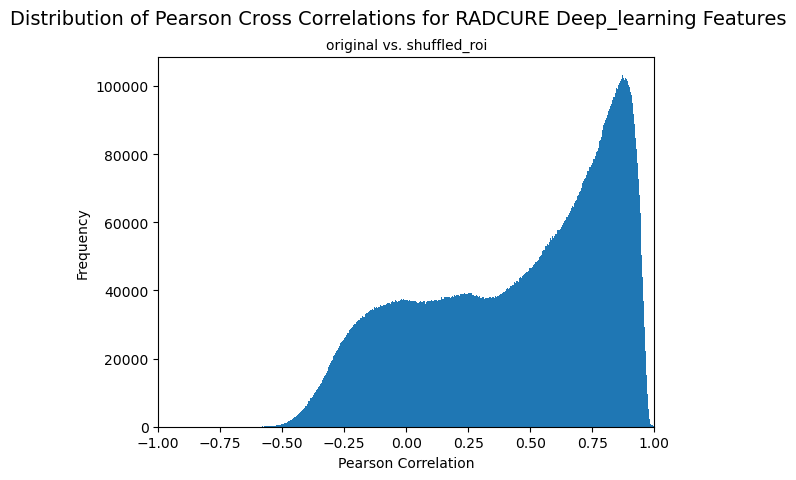

In [22]:
vertical_vs_horizontal_corr_plot, vertical_vs_horizontal_corr_dist_plot = makeBothCrossCorrelationPlots(correlation_matrix = feature_correlation_matrix,
                                                                                                        num_vertical_features = len(vertical_features.columns),
                                                                                                        vertical_feature_name = vertical_feature_name,
                                                                                                        horizontal_feature_name =  horizontal_feature_name,
                                                                                                        corr_cmap = CORR_COLOR_MAP,
                                                                                                        dist_num_bins = cross_dist_num_bins,
                                                                                                        dist_y_upper_bound = cross_dist_y_upper_bound,
                                                                                                        correlation_method = CORRELATION_METHOD,
                                                                                                        extraction_method = extraction_method,
                                                                                                        dataset_name = dataset_name)

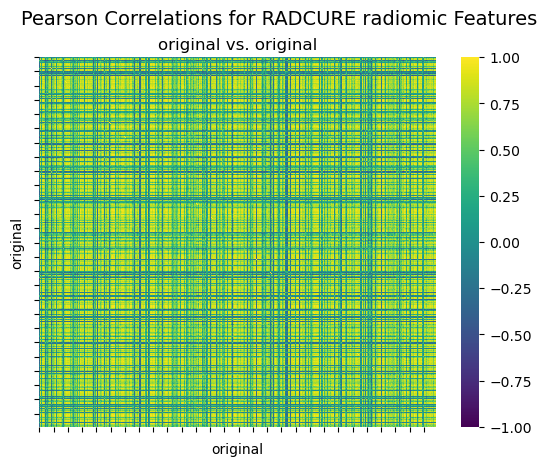

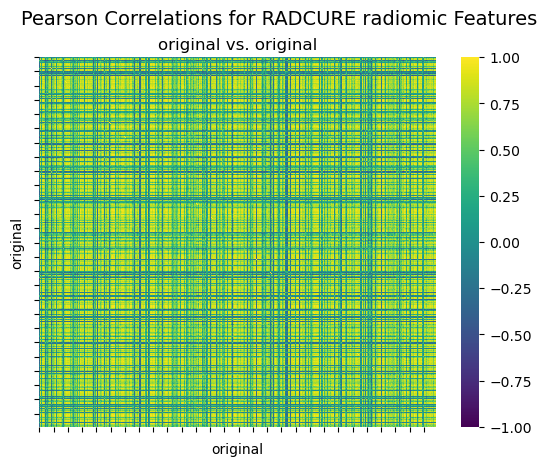

In [ ]:
from scripts.python.readii_analysis.analyze.correlation_functions import plotCorrelationHeatmap, getVerticalSelfCorrelations

orig_v_orig_corr_mat = getVerticalSelfCorrelations(feature_correlation_matrix,
                                                   num_vertical_features=len(vertical_features.columns))

plotCorrelationHeatmap(orig_v_orig_corr_mat,
                       diagonal=False,
                       cmap=CORR_COLOR_MAP,
                       xlabel="original",
                       ylabel="original",
                       title="Pearson Correlations for RADCURE radiomic Features",
                       subtitle="original vs. original")
